In [3]:
import pandas as pd

# Load
df = pd.read_csv("saas_users_hard_100.csv", parse_dates=["date"])

# Basic checks
print(df.head())
print(df.info())
print(df.describe())

# Sanity: sort by date (if not already)
df = df.sort_values("date").reset_index(drop=True)


        date  new_users  active_users  churned_users  total_users
0 2024-01-01        101           372             32         1069
1 2024-01-02         64           275             14         1119
2 2024-01-03        110           471             10         1219
3 2024-01-04         70           302             10         1279
4 2024-01-05         73           320             28         1324
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           100 non-null    datetime64[ns]
 1   new_users      100 non-null    int64         
 2   active_users   100 non-null    int64         
 3   churned_users  100 non-null    int64         
 4   total_users    100 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 4.0 KB
None
                      date   new_users  active_users  churned_users  \
count      

In [14]:
import numpy as np

# Rolling averages (smooth lines for dashboard look)
df["new_users_ma7"]    = df["new_users"].rolling(7, min_periods=1).mean()
df["active_users_ma7"] = df["active_users"].rolling(7, min_periods=1).mean()
df["churned_ma7"]      = df["churned_users"].rolling(7, min_periods=1).mean()

# Net growth (after churn)
df["net_growth"] = df["new_users"] - df["churned_users"]

# Retention proxy (active/new) – clip to avoid division by zero/infinite
df["retention_ratio"] = (df["active_users"] / df["new_users"]).replace([np.inf, -np.inf], np.nan).clip(upper=10)

# Campaign period indices (spike created roughly on days 31–50)
campaign_start_idx, campaign_end_idx = 30, 49
campaign_start = df.loc[campaign_start_idx, "date"]
campaign_end   = df.loc[campaign_end_idx,   "date"]

print("Campaign window:", campaign_start.date(), "→", campaign_end.date())

df.head()

Campaign window: 2024-01-31 → 2024-02-19


,date,new_users,active_users,churned_users,total_users,new_users_ma7,active_users_ma7,churned_ma7,net_growth,retention_ratio
0,2024-01-01,101,372,32,1069,101.000000,372.000000,32.000000,69,3.683168
1,2024-01-02,64,275,14,1119,82.500000,323.500000,23.000000,50,4.296875
2,2024-01-03,110,471,10,1219,91.666667,372.666667,18.666667,100,4.281818
3,2024-01-04,70,302,10,1279,86.250000,355.000000,16.500000,60,4.314286
4,2024-01-05,73,320,28,1324,83.600000,348.000000,18.800000,45,4.383562


In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))


<Figure size 1400x700 with 0 Axes>

<Figure size 1400x700 with 0 Axes>

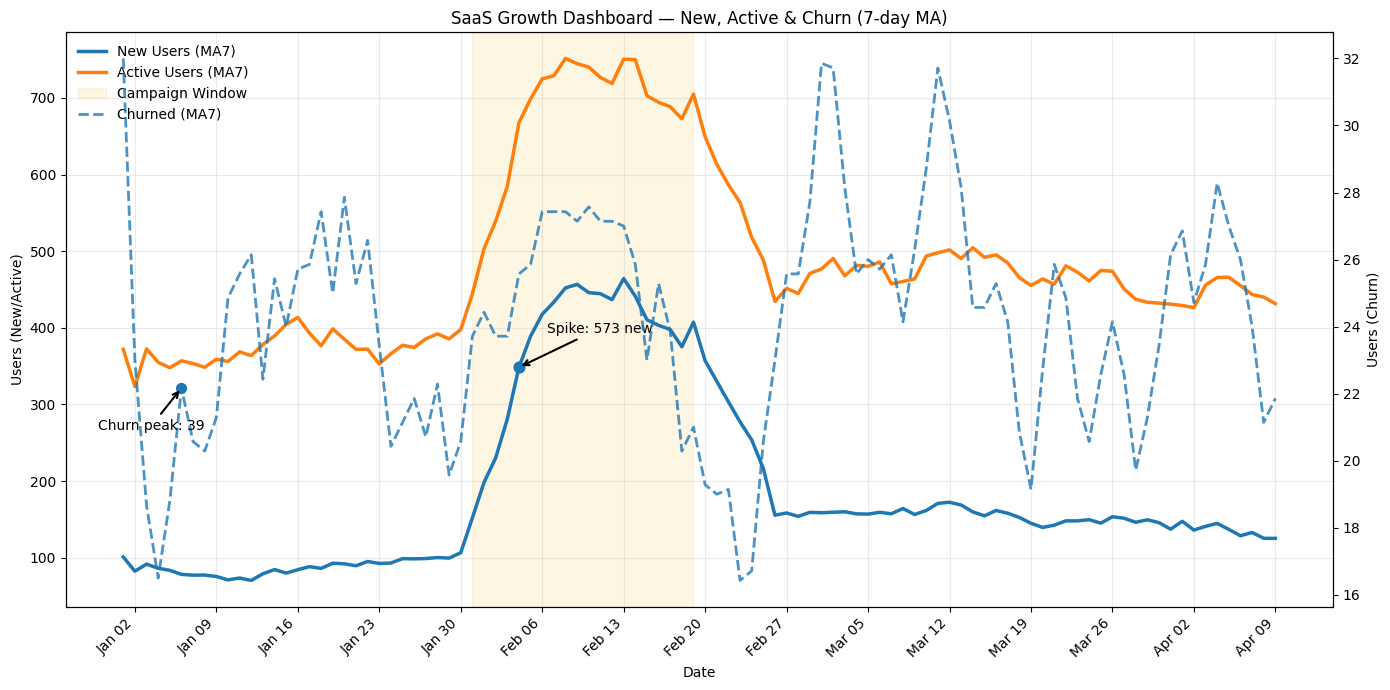

In [11]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14, 7))

# Left axis
ax = plt.gca()
ax.plot(df["date"], df["new_users_ma7"],  linewidth=2.5, label="New Users (MA7)")
ax.plot(df["date"], df["active_users_ma7"], linewidth=2.5, label="Active Users (MA7)")

# Right axis for churn
ax2 = ax.twinx()
ax2.plot(df["date"], df["churned_ma7"], linewidth=2.0, linestyle="--", label="Churned (MA7)", alpha=0.8)

# Campaign window highlight
ax.axvspan(campaign_start, campaign_end, color="#f5c542", alpha=0.15, label="Campaign Window")

# Annotations: max new users day
max_new_idx = df["new_users"].idxmax()
ax.scatter(df.loc[max_new_idx, "date"], df.loc[max_new_idx, "new_users_ma7"], s=60)
ax.annotate(
    f"Spike: {int(df.loc[max_new_idx, 'new_users'])} new",
    xy=(df.loc[max_new_idx, "date"], df.loc[max_new_idx, "new_users_ma7"]),
    xytext=(20, 25), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# Optional churn note near the local max churn
max_churn_idx = df["churned_users"].idxmax()
ax2.scatter(df.loc[max_churn_idx, "date"], df.loc[max_churn_idx, "churned_ma7"], s=50)
ax2.annotate(
    f"Churn peak: {int(df.loc[max_churn_idx, 'churned_users'])}",
    xy=(df.loc[max_churn_idx, "date"], df.loc[max_churn_idx, "churned_ma7"]),
    xytext=(-60, -30), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.5)
)

# Formatting
ax.set_title("SaaS Growth Dashboard — New, Active & Churn (7-day MA)")
ax.set_xlabel("Date")
ax.set_ylabel("Users (New/Active)")
ax2.set_ylabel("Users (Churn)")

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Legends from both axes
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=False)

ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()


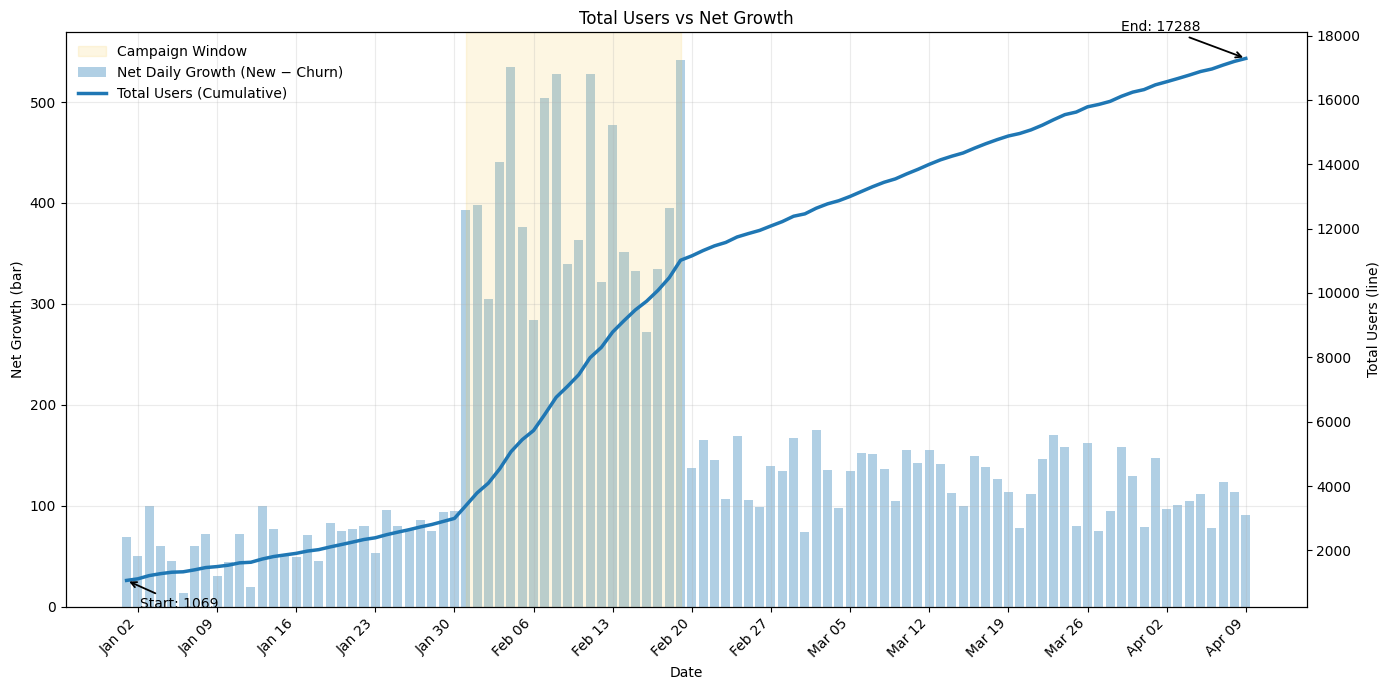

In [12]:
plt.figure(figsize=(14, 7))

ax = plt.gca()
# Bars for net growth
ax.bar(df["date"], df["net_growth"], alpha=0.35, label="Net Daily Growth (New − Churn)")

# Secondary axis for total users line
ax2 = ax.twinx()
ax2.plot(df["date"], df["total_users"], linewidth=2.5, label="Total Users (Cumulative)")

# Campaign window
ax.axvspan(campaign_start, campaign_end, color="#f5c542", alpha=0.15, label="Campaign Window")

# Annotations: starting & ending totals
ax2.annotate(
    f"Start: {int(df['total_users'].iloc[0])}",
    xy=(df["date"].iloc[0], df["total_users"].iloc[0]),
    xytext=(10, -20), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.3)
)
ax2.annotate(
    f"End: {int(df['total_users'].iloc[-1])}",
    xy=(df["date"].iloc[-1], df["total_users"].iloc[-1]),
    xytext=(-90, 20), textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.3)
)

# Formatting
ax.set_title("Total Users vs Net Growth")
ax.set_xlabel("Date")
ax.set_ylabel("Net Growth (bar)")
ax2.set_ylabel("Total Users (line)")

import matplotlib.dates as mdates
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %d"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# Legends
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc="upper left", frameon=False)

ax.grid(alpha=0.25)
plt.tight_layout()
plt.show()
